In [34]:
import random
from sklearn import datasets, model_selection
from neupy import algorithms, layers, environment
from sklearn.gaussian_process.kernels import *
import tensorflow as tf
from tensorflow import keras
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

In [38]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

import warnings
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
warnings.filterwarnings("ignore")

colors = plt.rcParams['axes.prop_cycle']
colors = [c['color'] for c in colors]
def plot_gp_bounds(x, y, x_predict, y_predict, y_std, ax=None):
    if ax is None:
        ax = plt.gca()
        
    bound1 = y_predict + 1.96 * y_std
    bound2 = y_predict - 1.96 * y_std

    ax.plot(x_predict, y_predict, color=colors[1])
    ax.plot(x_predict, bound1, color=colors[1])
    ax.plot(x_predict, bound2, color=colors[1])
    
    ax.fill_between(
        x_predict,
        bound1.reshape(len(bound1)),
        bound2.reshape(len(bound2)),
        alpha=0.3,
        color=colors[1],
    )
    ax.scatter(x, y, color=colors[1], s=50)
    
    return ax

-----------------------
Iteration #1
Number of hidden layers: 914
Epoch 1/100
13/13 [==============================] - 0s 3ms/step - loss: 2.4418 - accuracy: 0.3636
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 0.4701 - accuracy: 0.8528
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 0.2409 - accuracy: 0.9283
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1659 - accuracy: 0.9536
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1361 - accuracy: 0.9654
Epoch 6/100
13/13 [==============================] - 0s 2ms/step - loss: 0.1196 - accuracy: 0.9691
Epoch 7/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1085 - accuracy: 0.9759
Epoch 8/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1008 - accuracy: 0.9771
Epoch 9/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0893 - accuracy: 0.9827
Epoch 10/100
13/13 [=======================

ValueError: cannot reshape array of size 904401 into shape (951,)

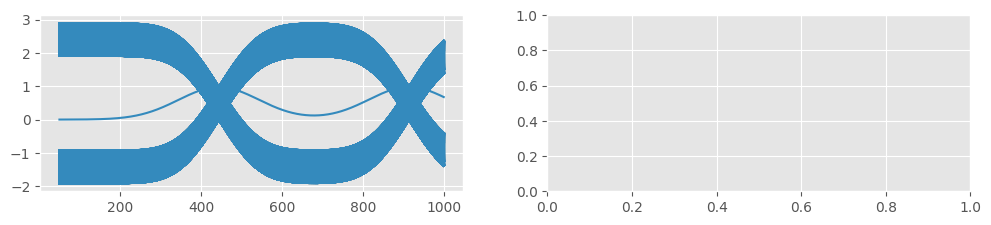

In [39]:
def vector_2d(array):
    return np.array(array).reshape((-1, 1))
    
def hyperparam_selection(func, n_hidden_range, func_args=None, n_iter=20):
    if func_args is None:
        func_args = []

    scores = []
    parameters = []

    min_n_hidden, max_n_hidden = n_hidden_range
    n_hidden_choices = np.arange(min_n_hidden, max_n_hidden + 1)
    
    for iteration in range(1, n_iter + 1):
        if iteration in (1, 2):
            n_hidden = random.randint(min_n_hidden, max_n_hidden)

        print('-----------------------')
        print('Iteration #{}'.format(iteration))
        print("Number of hidden layers: {}".format(n_hidden))

        nnet, score = func(n_hidden, *func_args)

        print("Cross entropy score: {}".format(score))

        parameters.append(n_hidden)
        scores.append(score)

        # To be able to perfome gaussian process we need to
        # have at least 2 samples.
        if iteration < 2:
            continue

        x_train = vector_2d(parameters)
        y_train = vector_2d(scores)
        x_test = vector_2d(n_hidden_choices)

        # Train gaussian process
        kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
        gp = GaussianProcessRegressor(kernel, n_restarts_optimizer=100)
        gp.fit(x_train, y_train)

        # Get mean and standard deviation for each possible
        # number of hidden units
        y_mean, y_std = gp.predict(x_test, return_std=True)
        y_std = vector_2d(y_std)

        y_min = min(scores)

        # Calculate expecte improvement from 95% confidence interval
        expected_improvement = y_min - (y_mean - 1.96 * y_std)
        expected_improvement[expected_improvement < 0] = 0

        max_index = expected_improvement.argmax()
        # Select next choice based on expected improvement
        n_hidden = n_hidden_choices[max_index]
        
        # Build plots
        ax1 = plt.subplot2grid((n_iter, 2), (iteration - 1, 0))
        ax2 = plt.subplot2grid((n_iter, 2), (iteration - 1, 1))
        
        order = np.argsort(parameters)

        plot_gp_bounds(x_train, y_train, n_hidden_choices, y_mean, y_std, ax1)
        ax1.scatter(parameters[-1], scores[-1], marker='*', s=150,
                    color=colors[0], zorder=10, label='Last step')
        ax1.set_title("Gaussian Process\nafter {} iterations".format(iteration))
        ax1.set_xlim(min_n_hidden - 10, max_n_hidden + 10)
        ax1.set_xlabel("Number of hidden units")
        ax1.set_ylabel("Cross entropy\n(the smaller the better)")
        ax1.legend(loc='upper right')
        
        ax2.plot(n_hidden_choices, expected_improvement)
        ax2.scatter(n_hidden_choices[max_index], expected_improvement[max_index],
                    marker='*', s=150, color=colors[1], label='Next step', zorder=10)
        ax2.set_xlim(min_n_hidden - 10, max_n_hidden + 10)
        ax2.set_title("Expected Improvement\nafter {} iterations".format(iteration))
        ax2.set_xlabel("Number of hidden units")
        
        if n_hidden > 450:
            ax2.legend(loc='upper left')
        else:
            ax2.legend(loc='upper right')
        
        if y_min == 0 or n_hidden in parameters:
            print("Converged")
            break
            
    min_score_index = np.argmin(scores)
    return parameters[min_score_index]
  # Randomly shuffle dataset before each
        # training epoch.  
def train_network(n_hidden, x_train, x_test, y_train, y_test):
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(64,)),
        keras.layers.Dense(n_hidden, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(x_train, y_train, epochs=100, batch_size=128)

    # Calculates categorical cross-entropy error between predicted value for x_test and y_test value
    loss, accuracy = model.evaluate(x_test, y_test)
    return model, accuracy

environment.reproducible()
import numpy as np
import matplotlib.pyplot as plt
dataset = datasets.load_digits()
n_samples = dataset.target.size
n_classes = 10
target = np.zeros((n_samples, n_classes))
target[np.arange(n_samples), dataset.target] = 1

x_train, x_test, y_train, y_test = model_selection.train_test_split(
    dataset.data, target, train_size=0.9
)

fig = plt.figure(figsize=(12, 16))
best_n_hidden = hyperparam_selection(
    train_network,
    n_hidden_range=[50, 1000],
    func_args=[x_train, x_test, y_train, y_test],
    n_iter=6,
)

print("")
print("Best number of hidden units: {}".format(best_n_hidden))

plt.tight_layout()
saveas('hyperparam-selection-nn-hidden-units')